# First implementation of Machine Learning Algorithm

In this file, we are going to import data from a file .csv that we take from chornograf.
We have to parse him and put into an array.
Finally we will insert some machin Learning algorithm with the librairy sklearn.

To do this, we will use some librairy as pandas, matplotlib, numpy, sklearn and some others.


In [1]:
from sklearn import linear_model
import csv
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Dans le fichier DataDemeterAll.csv

Toutes les données de puis 1970h à partir 7 mars au 28 mai

SELECT mean("temperature") AS "mean_temperature", mean("moisture-percent") AS "mean_moisture-percent" 

FROM "demeter"."autogen"."chirp-left" 

WHERE time > now() -1970h 

GROUP BY time(30m) FILL(null)

# Import des données 

Leccture d'un fichier csv en un fichier dataframe.

Création d'une base dataframe avec comme colonne le temps, l'humidité, la tempérture, l'humidité + 1, la température + 1.

Il faut régler le problème tu dernier temps.

In [2]:
from traitement import Traitement


df = pd.read_csv('DataDemeterAll.csv')

t= Traitement()

#Création des deux autres colonnes
df = t.ajoutData(df)

## Ajout de l'arrosage

L'arrosage est ajouté au temps 10h30 ou 11h30.

In [3]:
import datetime

df = t.arrosageHist(df,1)
df['index'] = df.index
nligne = df.shape[0]
position = df.shape[1]-1
for i in range(nligne):
    df.iloc[i,position] = (i-6)//48 + 1


# Delete NaN Value

In [4]:
i = 6

df = t.eliminateNaNValue(df,i)
#Delete the data that are not inside a loop of one day
df.drop(df.index[range(0,i+48*3)],axis = 0,inplace = True)
nligne = df.shape[0]
print("nombre de ligne", nligne)


nombre de ligne 3647


In [5]:
nligne = df.shape[0]
nColumn = df.shape[1]
print(df.isnull().sum())
for i in range(nligne):
    if df.iloc[i,:].isnull().values.any():
        print(df.index[i])
        

date                     0
mean_moisture-percent    0
mean_temperature         0
moistureAdd              0
temperatureAdd           0
Arrosage                 0
TAfterArrosage           0
ArrosageHist             0
index                    0
dtype: int64


# Data Test

Extraction des données aléatoire sur toutes les datasets. 7 jours entiers sont pris pour les tests.
Les données pour les Tests sont exclus des données pour le training

In [6]:
import random
jour = nligne //48
print("nb de jour de test : ",jour)
incr = 0
jourTest = random.sample(range(1,jour),k=10)
jourTest.sort()
print("jour de test : ",jourTest)


nb de jour de test :  75
jour de test :  [14, 18, 27, 29, 38, 45, 58, 72, 73, 74]


In [7]:
indTest = []
for el in jourTest:
    indTest = np.append(indTest,range(int(48*(el-1)),int(48*el)))
indTest = indTest.astype(int)
dataTest = df.iloc[indTest,:].copy()
df.drop(df.index[indTest],axis = 0,inplace = True)


In [8]:
dataTest

,date,mean_moisture-percent,mean_temperature,moistureAdd,temperatureAdd,Arrosage,TAfterArrosage,ArrosageHist,index
774,3/23/2019 10:30:00.000000000 AM,19.036667,25.841667,3.676667,-0.776667,10,0,10,17
775,3/23/2019 11:00:00.000000000 AM,22.713333,25.065000,-0.865000,0.735000,0,30,10,17
776,3/23/2019 11:30:00.000000000 AM,21.848333,25.800000,-0.775000,1.970000,0,60,10,17
777,3/23/2019 12:00:00.000000000 PM,21.073333,27.770000,-0.593333,3.740000,0,90,10,17
778,3/23/2019 12:30:00.000000000 PM,20.480000,31.510000,-0.366667,3.138333,0,120,10,17
779,3/23/2019 1:00:00.000000000 PM,20.113333,34.648333,-0.546667,2.283333,0,150,10,17
780,3/23/2019 1:30:00.000000000 PM,19.566667,36.931667,-0.386667,0.658333,0,180,10,17
781,3/23/2019 2:00:00.000000000 PM,19.180000,37.590000,-0.706667,1.251667,0,210,10,17
782,3/23/2019 2:30:00.000000000 PM,18.473333,38.841667,-0.555000,1.350000,0,240,10,17
783,3/23/2019 3:00:00.000000000 PM,17.918333,40.191667,-0.508333,2.245000,0,270,10,17


# Analyse de la dataFrame


## Linear Regression Multiple Variables sans l'information sur le temps sans arrosage



In [9]:
reg = linear_model.LinearRegression()
reg.fit(df[['mean_moisture-percent','mean_temperature','Arrosage']],df.moistureAdd)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [10]:
reg.coef_

array([-0.0294563 , -0.02040044,  0.23048426])

In [11]:
reg.intercept_

1.0286792644855625

In [12]:
reg.predict([[31,25,10]])[0]

1.9103654633601956

## Linear Regression Multiple Variables AVEC l'information sur le temps sans arrosage

In [13]:
reg2 = linear_model.LinearRegression()
reg2.fit(df[['mean_moisture-percent','mean_temperature','Arrosage','TAfterArrosage']],df.moistureAdd)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [14]:
reg2.coef_

array([ -2.62519370e-02,  -8.12577778e-03,   2.34878541e-01,
         1.57343807e-04])

In [15]:
reg2.intercept_

0.52026893369894012

In [16]:
reg2.predict([[31,25,10,0]])[0]

1.8520998526519277



# Test avec data Test

On fait nos tests avec notre dataTest créé ci-dessus

## Test avec les donnes SANS le temps

In [17]:
init = 0+48*0
dataTest['resultSansT'] = dataTest.index
position = dataTest.shape[1]-1

StartHumidity = dataTest.iloc[init,1]
TestSize = dataTest.shape[0]
result = np.zeros(TestSize)
for i in range(0,TestSize):
    dataTest.iloc[int(i+init),position] = StartHumidity

    if i%48 == 0:
        StartHumidity = dataTest.iloc[init+i,1]
    result[i] = StartHumidity + reg.predict([[StartHumidity,dataTest.iloc[init+i,2],dataTest.iloc[init+i,5]]])[0]
    StartHumidity = result[i]
    

#print(dfTest.iloc[range(0+init+1,TestSize+init+1),1])
ErrSansTemps = np.mean(dataTest.iloc[:,1].values-dataTest.iloc[:,position].values)
ErrSansTempsAbs = np.mean(np.absolute(dataTest.iloc[:,1].values-dataTest.iloc[:,position].values))

print("Moyenne d'erreur : ",ErrSansTemps)
print("Moyenne d'erreur absolue : ",ErrSansTempsAbs)


Moyenne d'erreur :  -0.93616293507
Moyenne d'erreur absolue :  1.86196790615


## Test avec les donnes AVEC le temps

In [18]:
init = 0+48*0
dataTest['resultAvecT'] = dataTest.index
position = dataTest.shape[1]-1

StartHumidity = dataTest.iloc[init,1]

TestSize = dataTest.shape[0]
result2 = np.zeros(TestSize)
for i in range(0,TestSize):
    dataTest.iloc[int(i+init),position] = StartHumidity

    if i%48 == 0:
        StartHumidity = dataTest.iloc[init+i,1]
    result2[i] = StartHumidity + reg2.predict([[StartHumidity,dataTest.iloc[init+i,2],dataTest.iloc[init+i,5],dataTest.iloc[init+i,6]]])[0]
    StartHumidity = result2[i]

#print(result2)
#print(dfTest.iloc[range(0+init+1,TestSize+init+1),1])
ErrTemps = np.mean(dataTest.iloc[:,1].values-dataTest.iloc[:,position].values)
ErrTempsAbs = np.mean(np.absolute(dataTest.iloc[:,1].values-dataTest.iloc[:,position].values))

print("Moyenne d'erreur : ",ErrTemps)
print("Moyenne d'erreur absolue : ",ErrTempsAbs)


Moyenne d'erreur :  -0.667365721568
Moyenne d'erreur absolue :  1.61679773997


# Partage de la Data frame

Partage de la data frame en deux. 

Une partie qui contient que les moments où on arrose. On peut selectionner ceci grace à loc et à df['TAfterArrosage'] == 0. Quand on arrose, le temps après arrosage est de 0.

L'autre partie contient les moments où on n'arrose pas. C'est-à-dire les momments où l'eau s'évapore.

In [19]:
limite = 270
dfArrosage = df.loc[df['TAfterArrosage'] == 0]
tmp = df.loc[df['TAfterArrosage'] > 0]
dfStabilisation = df.loc[df['TAfterArrosage'] > limite].copy()
dfEvaporation = tmp.loc[df['TAfterArrosage'] <= limite].copy()

In [20]:
regLinearAro = linear_model.LinearRegression()
regLinearAro.fit(dfArrosage[['mean_moisture-percent','Arrosage','index']],dfArrosage.moistureAdd)

regLinearAro.intercept_
regLinearAro.coef_


array([ 0.00781881,  0.15579306, -0.10006074])

In [21]:
# Pour faire le régression linear sur le moment d'arrosage

regLinearEva = linear_model.LinearRegression()
regLinearEva.fit(dfEvaporation[['mean_moisture-percent','mean_temperature','TAfterArrosage','ArrosageHist','index']],dfEvaporation.moistureAdd)

regLinearEva.intercept_
regLinearEva.coef_

array([-0.01656948, -0.04080076,  0.00834699, -0.01059847,  0.00722106])

In [22]:
# Pour faire le régression linear sur le moment d'arrosage

regLinearSta = linear_model.LinearRegression()
regLinearSta.fit(dfStabilisation[['mean_moisture-percent','mean_temperature','TAfterArrosage','ArrosageHist','index']],dfStabilisation.moistureAdd)

regLinearSta.intercept_
regLinearSta.coef_

array([ -4.87983728e-03,   3.96219090e-03,  -3.92819670e-07,
        -8.84675585e-04,   1.03501145e-03])

In [23]:
#Pour tester sur la base de données de training
init = 0
base = dataTest 

In [24]:
dataTest['resultSepare'] = dataTest.index
StartHumidity = base.iloc[init,1]
position = dataTest.shape[1]-1


TestSize = dataTest.shape[0]
ErrAro = 0
result = np.zeros(TestSize)
ErrEva = 0
nAro = 0

for i in range(0,TestSize-1):
    dataTest.iloc[int(i),position] = StartHumidity

    if i%48 == 0:
        nAro =+ 1
        StartHumidity = dataTest.iloc[i,1]
        result[i] = StartHumidity + regLinearAro.predict([[StartHumidity,base.iloc[init+i,5],base.iloc[init+i,8]]])[0]
        ErrAro =+ abs(result[i] - base.iloc[i+1,1])
    elif i%48 <= limite//30:
        result[i] = StartHumidity + regLinearEva.predict([[StartHumidity,base.iloc[init+i,2],base.iloc[init+i,6],base.iloc[init+i,7],base.iloc[init+i,8]]])[0]
        ErrEva =+ abs(result[i] - base.iloc[i+1,1])
    else:
        result[i] = StartHumidity + regLinearSta.predict([[StartHumidity,base.iloc[init+i,2],base.iloc[init+i,6],base.iloc[init+i,7],base.iloc[init+i,8]]])[0]
        ErrSta =+ abs(result[i] - base.iloc[i+1,1])

    StartHumidity = result[i]
dataTest.iloc[TestSize-1,position] = StartHumidity

ErrAro = ErrAro/nAro
ErrEva = ErrEva/(15*nAro)
ErrSta = ErrSta/((48-16*nAro))

print("Moyenne Erreur d'Arrosage : ", ErrAro)
print("Moyenne d'erreur evaporation : ", ErrEva)
print("Moyenne d'erreur stabilisation : ", ErrSta)

ErrSepare = np.mean(dataTest.iloc[:,1].values-dataTest.iloc[:,position].values)
ErrSepareAbs = np.mean(np.absolute(dataTest.iloc[:,1].values-dataTest.iloc[:,position].values))
print("Moyenne d'erreur : ",ErrSepare)
print("Moyenne d'erreur absolue : ",ErrSepareAbs)


Moyenne Erreur d'Arrosage :  0.0733192456571
Moyenne d'erreur evaporation :  0.139874842223
Moyenne d'erreur stabilisation :  0.0280383301989
Moyenne d'erreur :  0.101504328322
Moyenne d'erreur absolue :  0.895077835156


# Affichage des résultats

On Affiche les resultats

In [25]:
print("Sans le temps : ", ErrSansTemps)
print("Avec le temps : ", ErrTemps)

#print("\nDurant Arrosage : ",ErrAro)
#print("Evaporation : " , ErrEva)
print("Avec Temps Séparé : ", ErrSepare)


Sans le temps :  -0.93616293507
Avec le temps :  -0.667365721568
Avec Temps Séparé :  0.101504328322


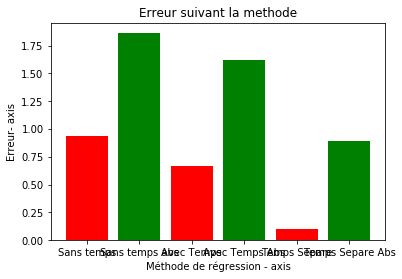

In [26]:
# x-coordinates of left sides of bars  
left = [1, 2, 3, 4, 5, 6] 
  
# heights of bars 
height = [ErrSansTemps,ErrSansTempsAbs, ErrTemps, ErrTempsAbs, ErrSepare,ErrSepareAbs]
height = [abs(x) for x in height]

  
# labels for bars 
tick_label = ['Sans temps', 'Sans temps abs', 'Avec Temps','Avec Temps Abs', 'Temps Separe','Temps Separe Abs'] 
  
# plotting a bar chart 
plt.bar(left, height, tick_label = tick_label, 
        width = 0.8, color = ['red', 'green']) 

# naming the x-axis 
plt.xlabel('Méthode de régression - axis') 
# naming the y-axis 
plt.ylabel('Erreur- axis') 
# plot title 
plt.title('Erreur suivant la methode') 
  
# function to show the plot 
plt.show() 

# Graphic

Creation des graphics de la courbe d'évolution de la température



Text(0,0.5,'moisture-percent')

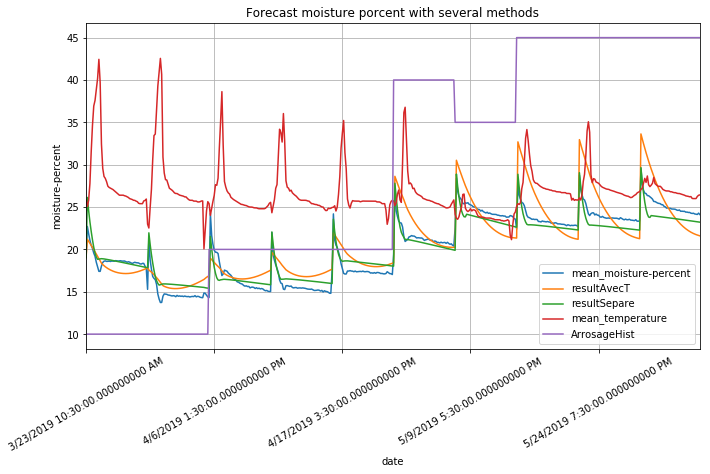

In [27]:
ax = dataTest.plot(x='date', y=['mean_moisture-percent','resultAvecT','resultSepare','mean_temperature','ArrosageHist'],figsize=(11, 6),rot=30,grid=True, title="Forecast moisture porcent with several methods")
ax.set_ylabel("moisture-percent")

#dfTest.loc[dfTest['TAfterArrosage'] == 30]

## recherche de la meilleures delimitation pour le partitionnement en 3



In [28]:
dfArrosage = df.loc[df['TAfterArrosage'] == 0]
tmp = df.loc[df['TAfterArrosage'] > 0]

bestLimite = 0
errmin = 1000
for limite in range(30,1200,30):
    
    dfStabilisation = df.loc[df['TAfterArrosage'] > limite].copy()
    dfEvaporation = tmp.loc[df['TAfterArrosage'] <= limite].copy()

    regLinearAro = linear_model.LinearRegression()
    regLinearAro.fit(dfArrosage[['mean_moisture-percent','Arrosage','index']],dfArrosage.moistureAdd)
    regLinearEva = linear_model.LinearRegression()
    regLinearEva.fit(dfEvaporation[['mean_moisture-percent','mean_temperature','TAfterArrosage','ArrosageHist','index']],dfEvaporation.moistureAdd)
    regLinearSta = linear_model.LinearRegression()
    regLinearSta.fit(dfStabilisation[['mean_moisture-percent','mean_temperature','TAfterArrosage','ArrosageHist','index']],dfStabilisation.moistureAdd)



    dataTest['resultSepare'] = dataTest.index
    StartHumidity = base.iloc[0,1]
    position = dataTest.shape[1]-1
    TestSize = dataTest.shape[0]
    result = np.zeros(TestSize)

    for i in range(0,TestSize-1):
        dataTest.iloc[int(i),position] = StartHumidity

        if i%48 == 0:
            StartHumidity = dataTest.iloc[i,1]
            result[i] = StartHumidity + regLinearAro.predict([[StartHumidity,base.iloc[i,5],base.iloc[i,8]]])[0]
        elif i%48 <= limite//30:
            result[i] = StartHumidity + regLinearEva.predict([[StartHumidity,base.iloc[i,2],base.iloc[i,6],base.iloc[i,7],base.iloc[i,8]]])[0]
        else:
            result[i] = StartHumidity + regLinearSta.predict([[StartHumidity,base.iloc[i,2],base.iloc[i,6],base.iloc[i,7],base.iloc[i,8]]])[0]

        StartHumidity = result[i]
    dataTest.iloc[TestSize-1,position] = StartHumidity


    ErrSepare = np.mean(dataTest.iloc[:,1].values-dataTest.iloc[:,position].values)
    ErrSepareAbs = np.mean(np.absolute(dataTest.iloc[:,1].values-dataTest.iloc[:,position].values))
    print("limite ", limite,"Moyenne d'erreur : ",ErrSepare)
    print("limite ", limite,"Moyenne d'erreur absolue : ",ErrSepareAbs)
    if (ErrSepareAbs< errmin):
        bestLimite = limite
        errmin = ErrSepareAbs

print("BEST LIMITE : ",bestLimite)

limite  30 Moyenne d'erreur :  0.017122794745
limite  30 Moyenne d'erreur absolue :  1.01888914709
limite  60 Moyenne d'erreur :  0.113108451957
limite  60 Moyenne d'erreur absolue :  0.949963036296
limite  90 Moyenne d'erreur :  0.204632578535
limite  90 Moyenne d'erreur absolue :  0.924754988545
limite  120 Moyenne d'erreur :  0.267354624627
limite  120 Moyenne d'erreur absolue :  0.946383411292
limite  150 Moyenne d'erreur :  0.294595174009
limite  150 Moyenne d'erreur absolue :  0.968426265741
limite  180 Moyenne d'erreur :  0.274727686477
limite  180 Moyenne d'erreur absolue :  0.990546007699
limite  210 Moyenne d'erreur :  0.206038470736
limite  210 Moyenne d'erreur absolue :  0.988958585389
limite  240 Moyenne d'erreur :  0.101504328322
limite  240 Moyenne d'erreur absolue :  0.895077835156
limite  270 Moyenne d'erreur :  -0.0624527309314
limite  270 Moyenne d'erreur absolue :  0.832678117327
limite  300 Moyenne d'erreur :  -0.21910158111
limite  300 Moyenne d'erreur absolue :  

Text(0,0.5,'moisture-percent')

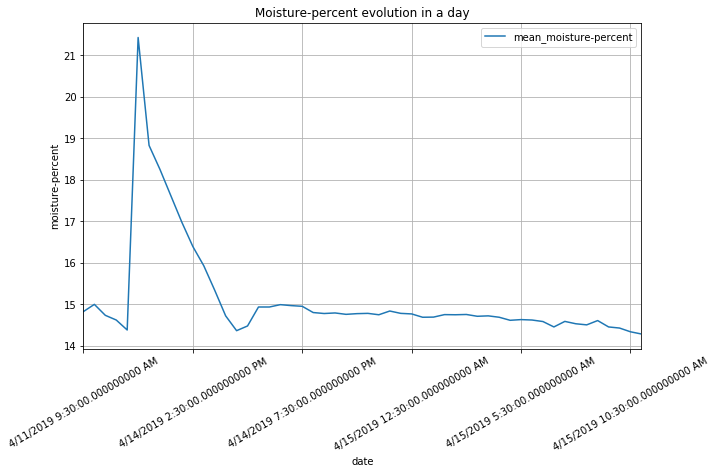

In [37]:
dfGraph = dataTest.iloc[range(44+48*4,96+48*4),:]
ax = dfGraph.plot(x='date', y=['mean_moisture-percent'],figsize=(10, 6),rot=30,grid=True, title="Moisture-percent evolution in a day")
ax.set_ylabel("moisture-percent")



# Erreur après 24heures

L'erreur ci-dessous représente l'erreur à la dernière itération.

In [83]:
dfEnd = dataTest.loc[dataTest['TAfterArrosage'] == 0]
EndSans = np.mean(dfEnd.iloc[:,8]-dfEnd.iloc[:,1])
EndAvec = np.mean(dfEnd.iloc[:,9]-dfEnd.iloc[:,1])
EndSepare = np.mean(dfEnd.iloc[:,10]-dfEnd.iloc[:,1])
EndAutre = np.mean(dfEnd.iloc[:,11]-dfEnd.iloc[:,1])

print("Sans le temps : ", EndSans)
print("Avec le temps : ", EndAvec)
print("Avec Temps Séparé : ", EndSepare)
print("Avec Lasso a = 1.5 : ", EndAutre)

Sans le temps :  0.283215586271
Avec le temps :  0.460079778198
Avec Temps Séparé :  0.935793977415
Avec Lasso a = 1.5 :  1.86370679354


In [84]:
regtest = linear_model.LinearRegression()
regtest.fit(df[['mean_moisture-percent','mean_temperature','Arrosage']],df.moistureAdd)

regtest.coef_
regtest.intercept_

0.82473593376527576

In [85]:
dfPure = df.loc[df['TAfterArrosage'] <= 30 ]